In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from PIL import Image


In [2]:
#train_dataset = VOCSegmentation(root='data/', year='2012', image_set='train', download=True)

# writing custom dataset, inheriting from VOCSegmentation dataset
class VOCSegmentationWithPIL(VOCSegmentation):
    def __init__(self, root='data', year='2012', image_set='train',
                 download=True, image_size=(224, 224)):
        super().__init__(root=root, year=year, image_set=image_set, download=download)
        self.image_resize = T.Resize(image_size)
        self.mask_transform = T.Compose([
            T.Resize(image_size, interpolation=Image.NEAREST),
            T.PILToTensor(),  # Keeps label values intact
        ])

    def __getitem__(self, index):
        image, mask = super().__getitem__(index)
        image = self.image_resize(image)  # still PIL.Image
        mask = self.mask_transform(mask).squeeze(0).long()  # [H, W] as LongTensor
        return image, mask

In [3]:
def collate_fn_pil(batch):
    images, masks = zip(*batch)  # tuple of lists
    return list(images), torch.stack(masks)  # keep images as list of PIL


In [4]:
train_dataset = VOCSegmentationWithPIL(
    root='src/data_train',
    year='2012',
    image_set='train',
    download=True,
    image_size=(224, 224)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn_pil,
    pin_memory=True
)

Using downloaded and verified file: src/data_train/VOCtrainval_11-May-2012.tar
Extracting src/data_train/VOCtrainval_11-May-2012.tar to src/data_train


In [5]:
val_dataset = VOCSegmentationWithPIL(
    root='src/data_val',
    year='2012',
    image_set='val',
    download=True,
    image_size=(224, 224)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn_pil,
    pin_memory=True
)

Using downloaded and verified file: src/data_val/VOCtrainval_11-May-2012.tar
Extracting src/data_val/VOCtrainval_11-May-2012.tar to src/data_val


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class UNetDecoder(nn.Module):
    def __init__(self, in_channels=1024, num_classes=21):
        super().__init__()

        # Upsample from 16x16 -> 32x32 -> 64x64 -> 128x128 -> 224x224
        self.up1 = self._upsample_block(in_channels, 512)
        self.up2 = self._upsample_block(512, 256)
        self.up3 = self._upsample_block(256, 128)
        self.up4 = self._upsample_block(128, 64)

        # Skip connections
        self.skip_32 = nn.Conv2d(in_channels, 512, kernel_size=1)
        self.skip_64 = nn.Conv2d(512, 256, kernel_size=1)
        self.skip_128 = nn.Conv2d(256, 128, kernel_size=1)

        # Final prediction layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

        # Auxiliary outputs (for deeper supervision)
        self.aux1_conv = nn.Conv2d(128, num_classes, kernel_size=1)  # from x3
        self.aux2_conv = nn.Conv2d(64, num_classes, kernel_size=1)   # from x4    
    
    def _upsample_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2)  # just Added dropout to regularize because it was observed after 20 epoch it was overfitting
        )

    def forward(self, x):
        # x: [B, 1024, 16, 16]

        x1 = self.up1(x)  # 16 -> 32
        skip_32 = F.interpolate(self.skip_32(x), size=x1.shape[2:], mode='bilinear', align_corners=False)
        x1 = x1 + skip_32

        x2 = self.up2(x1)  # 32 -> 64
        skip_64 = F.interpolate(self.skip_64(x1), size=x2.shape[2:], mode='bilinear', align_corners=False)
        x2 = x2 + skip_64

        x3 = self.up3(x2)  # 64 -> 128
        skip_128 = F.interpolate(self.skip_128(x2), size=x3.shape[2:], mode='bilinear', align_corners=False)
        x3 = x3 + skip_128

        x4 = self.up4(x3)  # 128 -> 256

        # Main output
        x_out = F.interpolate(x4, size=(224, 224), mode='bilinear', align_corners=False)
        x_out = self.final_conv(x_out)

        # Auxiliary outputs
        aux1 = F.interpolate(self.aux1_conv(x3), size=(224, 224), mode='bilinear', align_corners=False)
        aux2 = F.interpolate(self.aux2_conv(x4), size=(224, 224), mode='bilinear', align_corners=False)

        return x_out, aux1, aux2

In [7]:
import torch
from transformers import AutoImageProcessor, Dinov2Model

In [8]:
class DinoSegModel(nn.Module):
    def __init__(self, freeze_dino=True, num_classes=21):
        super().__init__()
        self.dino = Dinov2Model.from_pretrained("facebook/dinov2-large")
        self.decoder = UNetDecoder(in_channels=1024, num_classes=num_classes)
        

        if freeze_dino:
            # Step 1: Freeze all
            for param in self.dino.parameters():
                param.requires_grad = False

            # Step 2: Unfreeze layers 18-23 explicitly
            for i in range(22, 24):
                for name, param in self.dino.named_parameters():
                    if f"encoder.layer.{i}." in name:
                        param.requires_grad = True


    def forward(self, pixel_values):  # Input: [B, 3, 224, 224]
        feats = self.dino(pixel_values).last_hidden_state  # [B, 257, 1024]
        feats = feats[:, 1:, :]  # remove CLS token
        feats = feats.reshape(-1, 16, 16, 1024).permute(0, 3, 1, 2)  # [B, 1024, 16, 16]

        x_out, aux1, aux2 = self.decoder(feats)
        #x_out = self.decoder(feats)
        return x_out, aux1, aux2

In [9]:
rand = torch.rand(8, 3, 224, 224)
model = DinoSegModel(freeze_dino=True, num_classes=19)
op, ax1, ax2 = model(rand)
op.shape, ax1.shape, ax2.shape

(torch.Size([8, 19, 224, 224]),
 torch.Size([8, 19, 224, 224]),
 torch.Size([8, 19, 224, 224]))

In [22]:
# model = DinoSegModel()
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
    else:
        print(f"Frozen: {name}")

Frozen: dino.embeddings.cls_token
Frozen: dino.embeddings.mask_token
Frozen: dino.embeddings.position_embeddings
Frozen: dino.embeddings.patch_embeddings.projection.weight
Frozen: dino.embeddings.patch_embeddings.projection.bias
Frozen: dino.encoder.layer.0.norm1.weight
Frozen: dino.encoder.layer.0.norm1.bias
Frozen: dino.encoder.layer.0.attention.attention.query.weight
Frozen: dino.encoder.layer.0.attention.attention.query.bias
Frozen: dino.encoder.layer.0.attention.attention.key.weight
Frozen: dino.encoder.layer.0.attention.attention.key.bias
Frozen: dino.encoder.layer.0.attention.attention.value.weight
Frozen: dino.encoder.layer.0.attention.attention.value.bias
Frozen: dino.encoder.layer.0.attention.output.dense.weight
Frozen: dino.encoder.layer.0.attention.output.dense.bias
Frozen: dino.encoder.layer.0.layer_scale1.lambda1
Frozen: dino.encoder.layer.0.norm2.weight
Frozen: dino.encoder.layer.0.norm2.bias
Frozen: dino.encoder.layer.0.mlp.fc1.weight
Frozen: dino.encoder.layer.0.mlp.fc

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from transformers import Dinov2Model


# class SimplePixelDecoder(nn.Module):
#     """
#     A simplified version of Mask2Former's pixel decoder.
#     Converts DINO features into multi-scale features for the transformer decoder.
#     """
#     def __init__(self, in_channels=1024, embed_dim=256):
#         super().__init__()
#         self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=1)
#         self.out_norm = nn.BatchNorm2d(embed_dim)

#     def forward(self, x):
#         # x: [B, 1024, 16, 16] -> [B, 256, 16, 16]
#         x = self.proj(x)
#         x = self.out_norm(x)
#         return x


# class TransformerDecoder(nn.Module):
#     """
#     A simplified transformer decoder for segmentation.
#     Inspired by Mask2Former: takes features and learns query embeddings to predict masks.
#     """
#     def __init__(self, embed_dim=256, num_queries=100, num_classes=21):
#         super().__init__()
#         self.query_embed = nn.Embedding(num_queries, embed_dim)
#         self.transformer_decoder_layer = nn.TransformerDecoderLayer(embed_dim, nhead=8, dim_feedforward=1024)
#         self.transformer_decoder = nn.TransformerDecoder(self.transformer_decoder_layer, num_layers=6)
#         self.class_embed = nn.Linear(embed_dim, num_classes)
#         self.mask_embed = nn.Sequential(
#             nn.Linear(embed_dim, embed_dim),
#             nn.ReLU(),
#             nn.Linear(embed_dim, embed_dim)
#         )

#     def forward(self, x):
#         # x: [B, C, H, W] -> [B, HW, C]
#         B, C, H, W = x.shape
#         x_flat = x.flatten(2).permute(2, 0, 1)  # [HW, B, C]
#         query_embed = self.query_embed.weight.unsqueeze(1).repeat(1, B, 1)  # [num_queries, B, C]

#         tgt = torch.zeros_like(query_embed)  # [num_queries, B, C]
#         hs = self.transformer_decoder(tgt, x_flat)  # [num_queries, B, C]

#         hs = hs.transpose(0, 1)  # [B, num_queries, C]
#         class_logits = self.class_embed(hs)  # [B, num_queries, num_classes]
#         mask_embed = self.mask_embed(hs)  # [B, num_queries, C]

#         # Predict masks: linear projection to per-pixel mask logits
#         masks = torch.einsum("bqc, bchw -> bqhw", mask_embed, x)

#         return class_logits, masks


# class DINO_Mask2Former_Segmentation(nn.Module):
#     def __init__(self, num_classes=21, freeze_dino=True):
#         super().__init__()
#         self.dino = Dinov2Model.from_pretrained("facebook/dinov2-large")
#         self.pixel_decoder = SimplePixelDecoder(in_channels=1024, embed_dim=256)
#         self.transformer_decoder = TransformerDecoder(embed_dim=256, num_queries=100, num_classes=num_classes)

#         if freeze_dino:
#             for param in self.dino.parameters():
#                 param.requires_grad = False
#             for name, param in self.dino.named_parameters():
#                 if any(f"blocks.{i}" in name for i in range(18, 24)):
#                     param.requires_grad = True

#     def forward(self, pixel_values):
#         # pixel_values: [B, 3, 224, 224]
#         feats = self.dino(pixel_values).last_hidden_state  # [B, 257, 1024]
#         feats = feats[:, 1:, :].reshape(-1, 16, 16, 1024).permute(0, 3, 1, 2)  # [B, 1024, 16, 16]

#         pixel_feats = self.pixel_decoder(feats)  # [B, 256, 16, 16]
#         class_logits, masks = self.transformer_decoder(pixel_feats)  # logits: [B, Q, C], masks: [B, Q, H, W]

#         return {
#             "class_logits": class_logits,  # For classification loss (cross-entropy)
#             "masks": masks                # For mask loss (e.g., BCE or dice)
#         }



In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### With checkpoints

In [ ]:
# from src.lovasz_losses import lovasz_softmax
# def hybrid_loss_fn(logits, target, ignore_index=255):
#     ce = F.cross_entropy(logits, target, ignore_index=ignore_index)
#     lv = lovasz_softmax(logits, target, ignore=ignore_index)
#     return ce + lv

In [26]:
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassJaccardIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# ------------------ Setup ------------------
num_classes = 21
ignore_index = 255
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = DinoSegModel(freeze_dino=True).to(device)
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(ignore_index=ignore_index)

# from src.lovasz_losses import lovasz_softmax
# def lovasz_loss_fn(logits, targets):
#     return lovasz_softmax(logits, targets, ignore=255)
# criterion = lovasz_loss_fn

#criterion = hybrid_loss_fn

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Metric
miou_metric = MulticlassJaccardIndex(num_classes=num_classes, ignore_index=ignore_index).to(device)

# Training config
num_epochs = 50
train_losses, val_losses, val_ious = [], [], []

# Paths
best_model_path = "best_model.pth"
checkpoint_path = "last_checkpoint.pth"
best_val_loss = float('inf')
start_epoch = 0

# ------------------ Load from Checkpoint (if exists) ------------------
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resumed training from checkpoint at epoch {start_epoch}")

# ------------------ Validation ------------------
def evaluate(model, loader, criterion, image_processor, device, epoch):
    model.eval()
    val_loss = 0.0
    miou_metric.reset()
    save_dir = os.path.join("val_preds_kitto", f"epoch_{epoch+1}")
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        val_loop = tqdm(loader, desc=f"Validation Epoch {epoch+1}")
        for step, (images, masks) in enumerate(val_loop):
            #inputs = image_processor(images, return_tensors='pt').to(device)

            inputs = torch.stack([T.ToTensor()(img) for img in images]).to(device)
            inputs = T.Normalize(mean=[0.5]*3, std=[0.5]*3)(inputs)

            masks = masks.to(device)
            
            #outputs, _, _ = model(inputs.pixel_values)
            # outputs, _, _ = model(inputs)
            # loss = criterion(outputs, masks)
            
            #out, aux1, aux2 = model(inputs.pixel_values) # if using AutoImageProcessor of DINO
            out, aux1, aux2 = model(inputs)
            main_loss = criterion(out, masks)
            aux_loss1 = criterion(aux1, F.interpolate(masks.unsqueeze(1).float(), size=aux1.shape[2:], mode='nearest').squeeze(1).long())
            aux_loss2 = criterion(aux2, F.interpolate(masks.unsqueeze(1).float(), size=aux2.shape[2:], mode='nearest').squeeze(1).long())
            loss = main_loss + 0.4 * aux_loss1 + 0.4 * aux_loss2
        
            val_loss += loss.item()
            val_loop.set_postfix(val_loss=loss.item())

            #preds = outputs.argmax(dim=1)
            preds = out.argmax(dim=1)
            miou_metric.update(preds, masks)

            # Save every sample in the batch
            for i in range(len(images)):
                #image_np = images[i]
                mask_np = masks[i].cpu().numpy()
                pred_np = preds[i].cpu().numpy()

                #plt.imsave(os.path.join(save_dir, f"image_{step}_{i}.jpg"), image_np)
                plt.imsave(os.path.join(save_dir, f"gt_{step}_{i}.png"), mask_np, cmap='nipy_spectral')
                plt.imsave(os.path.join(save_dir, f"pred_{step}_{i}.png"), pred_np, cmap='nipy_spectral')

    return val_loss / len(loader), miou_metric.compute().item()

# ------------------ Training Loop ------------------
for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, masks in loop:
        #inputs = image_processor(images, return_tensors='pt').to(device)
        
        inputs = torch.stack([T.ToTensor()(img) for img in images]).to(device)
        inputs = T.Normalize(mean=[0.5]*3, std=[0.5]*3)(inputs)
        
        masks = masks.to(device)

        #outputs, _, _ = model(inputs.pixel_values)
        # outputs, _, _ = model(inputs)
        # loss = criterion(outputs, masks)
        
        #out, aux1, aux2 = model(inputs.pixel_values)
        out, aux1, aux2 = model(inputs)
        main_loss = criterion(out, masks)
        aux_loss1 = criterion(aux1, F.interpolate(masks.unsqueeze(1).float(), size=aux1.shape[2:], mode='nearest').squeeze(1).long())
        aux_loss2 = criterion(aux2, F.interpolate(masks.unsqueeze(1).float(), size=aux2.shape[2:], mode='nearest').squeeze(1).long())
        loss = main_loss + 0.4 * aux_loss1 + 0.4 * aux_loss2
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluate only every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_val_loss, val_miou = evaluate(model, val_loader, criterion, image_processor, device, epoch)
        scheduler.step(avg_val_loss)
        val_losses.append(avg_val_loss)
        val_ious.append(val_miou)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val mIoU: {val_miou:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model at epoch {epoch+1} with val loss {avg_val_loss:.4f}")
    else:
        val_losses.append(None)
        val_ious.append(None)

    # Save checkpoint every epoch
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")


Resumed training from checkpoint at epoch 30


Epoch 31/50: 100%|██████████| 183/183 [00:27<00:00,  6.57it/s, loss=0.036] 


Checkpoint saved at epoch 31


Epoch 32/50: 100%|██████████| 183/183 [00:27<00:00,  6.56it/s, loss=0.0593]


Checkpoint saved at epoch 32


Epoch 33/50: 100%|██████████| 183/183 [00:27<00:00,  6.56it/s, loss=0.137] 


Checkpoint saved at epoch 33


Epoch 34/50: 100%|██████████| 183/183 [00:27<00:00,  6.57it/s, loss=0.0862]


Checkpoint saved at epoch 34


Epoch 35/50: 100%|██████████| 183/183 [00:27<00:00,  6.57it/s, loss=0.0931]


Checkpoint saved at epoch 35


Epoch 36/50: 100%|██████████| 183/183 [00:27<00:00,  6.54it/s, loss=0.0643]


Checkpoint saved at epoch 36


Epoch 37/50: 100%|██████████| 183/183 [00:28<00:00,  6.52it/s, loss=0.0592]


Checkpoint saved at epoch 37


Epoch 38/50: 100%|██████████| 183/183 [00:28<00:00,  6.52it/s, loss=0.0779]


Checkpoint saved at epoch 38


Epoch 39/50: 100%|██████████| 183/183 [00:28<00:00,  6.53it/s, loss=0.0394]


Checkpoint saved at epoch 39


Validation Epoch 40: 100%|██████████| 182/182 [00:25<00:00,  7.08it/s, val_loss=0.0458]


Epoch 40 | Train Loss: 0.0641 | Val Loss: 0.2968 | Val mIoU: 0.8275
Checkpoint saved at epoch 40


Epoch 41/50: 100%|██████████| 183/183 [00:28<00:00,  6.51it/s, loss=0.0432]


Checkpoint saved at epoch 41


Epoch 42/50: 100%|██████████| 183/183 [00:28<00:00,  6.51it/s, loss=0.0459]


Checkpoint saved at epoch 42


Epoch 43/50: 100%|██████████| 183/183 [00:28<00:00,  6.54it/s, loss=0.0373]


Checkpoint saved at epoch 43


Epoch 44/50: 100%|██████████| 183/183 [00:28<00:00,  6.54it/s, loss=0.0754]


Checkpoint saved at epoch 44


Epoch 45/50: 100%|██████████| 183/183 [00:28<00:00,  6.54it/s, loss=0.0425]


Checkpoint saved at epoch 45


Epoch 46/50: 100%|██████████| 183/183 [00:28<00:00,  6.53it/s, loss=0.0246]


Checkpoint saved at epoch 46


Epoch 47/50: 100%|██████████| 183/183 [00:28<00:00,  6.53it/s, loss=0.19]  


Checkpoint saved at epoch 47


Epoch 48/50: 100%|██████████| 183/183 [00:28<00:00,  6.53it/s, loss=0.0943]


Checkpoint saved at epoch 48


Epoch 49/50: 100%|██████████| 183/183 [00:28<00:00,  6.51it/s, loss=0.0232]


Checkpoint saved at epoch 49


Validation Epoch 50: 100%|██████████| 182/182 [00:25<00:00,  7.09it/s, val_loss=0.0347]


Epoch 50 | Train Loss: 0.0484 | Val Loss: 0.2915 | Val mIoU: 0.8329
Checkpoint saved at epoch 50


In [30]:
#from torchinfo import summary

# Print the model architecture and parameter summary
#summary(model, input_size=(1, 3, 224, 224), device=device.type)



In [ ]:
# from torchviz import make_dot

# dummy_input = torch.randn(1, 3, 224, 224).to(device)
# out, _, _ = model(dummy_input)

# make_dot(out, params=dict(model.named_parameters())).render("model_graph", format="png")

# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad={param.requires_grad}, shape={param.shape}")


In [32]:
from torch.utils.data import Dataset
from PIL import Image
import os

class KITTISegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(224, 224)):
        self.image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png') or fname.endswith('.jpg')])
        self.mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')])

        self.image_transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor(),
            T.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
        
        self.mask_transform = T.Compose([
            T.Resize(image_size, interpolation=Image.NEAREST),
            T.PILToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx])  # Assumes masks are already in correct class format
        return self.image_transform(image), self.mask_transform(mask).squeeze(0).long()


In [ ]:
kitti_dataset = KITTISegmentationDataset(
    image_dir='kitti_data/training/image_2',
    mask_dir='kitti_data/training/semantic',
    image_size=(224, 224)
)

kitti_loader = DataLoader(
    kitti_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [ ]:
#model = DinoSegModel(freeze_dino=True, num_classes=21).to(device)
#model.load_state_dict(torch.load("/home/iiitb/Desktop/anant/playground/ProjectBytes/best_model.pth", map_location=device))
#model.eval()


DinoSegModel(
  (dino): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-23): 24 x Dinov2Layer(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
 

In [35]:
count = 0
for images, masks in kitti_loader:
        # print(images.shape, masks.shape)
        # print("Unique labels in masks:", torch.unique(masks))
        count += 1 
        # if count ==100:
        #         break
        
print(count)

25


In [38]:
model

DinoSegModel(
  (dino): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-23): 24 x Dinov2Layer(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
 

In [44]:
device

device(type='cuda')

In [45]:
# Load model trained on VOC
model = DinoSegModel(freeze_dino=True).to(device)
model.load_state_dict(torch.load("best_model.pth"))

# Replace final head (assume it's named `self.head`)
# If it's DPT or Linear, adjust the naming accordingly.
num_kitti_classes = 34
#model.head[4] = nn.Conv2d(256, num_kitti_classes, kernel_size=1)
model.decoder.final_conv = nn.Conv2d(64, 34, kernel_size=1)
model.decoder.aux1_conv = nn.Conv2d(128, 34, kernel_size=1)
model.decoder.aux2_conv = nn.Conv2d(64, 34, kernel_size=1)

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the new classifier layers
for layer in [model.decoder.final_conv, model.decoder.aux1_conv, model.decoder.aux2_conv]:
    for param in layer.parameters():
        param.requires_grad = True

In [46]:
# Confirm:
for name, param in model.named_parameters():
    print(f"{name} - requires_grad: {param.requires_grad}")

dino.embeddings.cls_token - requires_grad: False
dino.embeddings.mask_token - requires_grad: False
dino.embeddings.position_embeddings - requires_grad: False
dino.embeddings.patch_embeddings.projection.weight - requires_grad: False
dino.embeddings.patch_embeddings.projection.bias - requires_grad: False
dino.encoder.layer.0.norm1.weight - requires_grad: False
dino.encoder.layer.0.norm1.bias - requires_grad: False
dino.encoder.layer.0.attention.attention.query.weight - requires_grad: False
dino.encoder.layer.0.attention.attention.query.bias - requires_grad: False
dino.encoder.layer.0.attention.attention.key.weight - requires_grad: False
dino.encoder.layer.0.attention.attention.key.bias - requires_grad: False
dino.encoder.layer.0.attention.attention.value.weight - requires_grad: False
dino.encoder.layer.0.attention.attention.value.bias - requires_grad: False
dino.encoder.layer.0.attention.output.dense.weight - requires_grad: False
dino.encoder.layer.0.attention.output.dense.bias - require

In [52]:
# Loss and Optimizer (only last layer is trainable)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model = model.to(device)

# Fine-tuning loop
model.train()
num_epochs = 50  # since you're just adapting the head
for epoch in range(num_epochs):
    total_loss = 0.0
    loop = tqdm(kitti_loader, desc=f"Fine-tuning Epoch {epoch+1}")

    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        images = T.Normalize(mean=[0.5]*3, std=[0.5]*3)(images)

        out, _, _ = model(images)
        loss = criterion(out, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Loss: {total_loss/len(kitti_loader):.4f}")


Fine-tuning Epoch 1: 100%|██████████| 25/25 [00:03<00:00,  8.24it/s, loss=2.11]


Epoch 1 Loss: 2.0700


Fine-tuning Epoch 2: 100%|██████████| 25/25 [00:03<00:00,  8.27it/s, loss=2.13]


Epoch 2 Loss: 2.0436


Fine-tuning Epoch 3: 100%|██████████| 25/25 [00:03<00:00,  8.28it/s, loss=2.11]


Epoch 3 Loss: 2.0236


Fine-tuning Epoch 4: 100%|██████████| 25/25 [00:03<00:00,  8.18it/s, loss=2.12]


Epoch 4 Loss: 2.0131


Fine-tuning Epoch 5: 100%|██████████| 25/25 [00:03<00:00,  8.18it/s, loss=2.13]


Epoch 5 Loss: 2.0018


Fine-tuning Epoch 6: 100%|██████████| 25/25 [00:03<00:00,  8.31it/s, loss=2.07]


Epoch 6 Loss: 1.9800


Fine-tuning Epoch 7: 100%|██████████| 25/25 [00:03<00:00,  8.25it/s, loss=2.05]


Epoch 7 Loss: 1.9709


Fine-tuning Epoch 8: 100%|██████████| 25/25 [00:03<00:00,  8.26it/s, loss=2.03]


Epoch 8 Loss: 1.9591


Fine-tuning Epoch 9: 100%|██████████| 25/25 [00:03<00:00,  8.26it/s, loss=2.04]


Epoch 9 Loss: 1.9505


Fine-tuning Epoch 10: 100%|██████████| 25/25 [00:03<00:00,  8.23it/s, loss=2]   


Epoch 10 Loss: 1.9401


Fine-tuning Epoch 11: 100%|██████████| 25/25 [00:03<00:00,  8.22it/s, loss=2.01]


Epoch 11 Loss: 1.9257


Fine-tuning Epoch 12: 100%|██████████| 25/25 [00:03<00:00,  8.25it/s, loss=1.98]


Epoch 12 Loss: 1.9303


Fine-tuning Epoch 13: 100%|██████████| 25/25 [00:03<00:00,  8.24it/s, loss=1.99]


Epoch 13 Loss: 1.9121


Fine-tuning Epoch 14: 100%|██████████| 25/25 [00:03<00:00,  8.29it/s, loss=2]   


Epoch 14 Loss: 1.9171


Fine-tuning Epoch 15: 100%|██████████| 25/25 [00:03<00:00,  8.23it/s, loss=1.96]


Epoch 15 Loss: 1.9035


Fine-tuning Epoch 16: 100%|██████████| 25/25 [00:03<00:00,  8.24it/s, loss=1.99]


Epoch 16 Loss: 1.9024


Fine-tuning Epoch 17: 100%|██████████| 25/25 [00:03<00:00,  8.22it/s, loss=1.97]


Epoch 17 Loss: 1.9002


Fine-tuning Epoch 18: 100%|██████████| 25/25 [00:03<00:00,  8.24it/s, loss=1.97]


Epoch 18 Loss: 1.8929


Fine-tuning Epoch 19: 100%|██████████| 25/25 [00:03<00:00,  8.27it/s, loss=1.97]


Epoch 19 Loss: 1.8942


Fine-tuning Epoch 20: 100%|██████████| 25/25 [00:03<00:00,  8.20it/s, loss=1.96]


Epoch 20 Loss: 1.8910


Fine-tuning Epoch 21: 100%|██████████| 25/25 [00:03<00:00,  8.29it/s, loss=1.97]


Epoch 21 Loss: 1.8866


Fine-tuning Epoch 22: 100%|██████████| 25/25 [00:03<00:00,  8.30it/s, loss=1.97]


Epoch 22 Loss: 1.8798


Fine-tuning Epoch 23: 100%|██████████| 25/25 [00:03<00:00,  8.18it/s, loss=1.98]


Epoch 23 Loss: 1.8852


Fine-tuning Epoch 24: 100%|██████████| 25/25 [00:03<00:00,  8.22it/s, loss=1.95]


Epoch 24 Loss: 1.8702


Fine-tuning Epoch 25: 100%|██████████| 25/25 [00:03<00:00,  8.25it/s, loss=1.95]


Epoch 25 Loss: 1.8726


Fine-tuning Epoch 26: 100%|██████████| 25/25 [00:03<00:00,  8.20it/s, loss=1.97]


Epoch 26 Loss: 1.8675


Fine-tuning Epoch 27: 100%|██████████| 25/25 [00:03<00:00,  8.19it/s, loss=1.97]


Epoch 27 Loss: 1.8645


Fine-tuning Epoch 28: 100%|██████████| 25/25 [00:03<00:00,  8.21it/s, loss=1.97]


Epoch 28 Loss: 1.8586


Fine-tuning Epoch 29: 100%|██████████| 25/25 [00:03<00:00,  8.14it/s, loss=1.98]


Epoch 29 Loss: 1.8673


Fine-tuning Epoch 30: 100%|██████████| 25/25 [00:03<00:00,  8.20it/s, loss=1.92]


Epoch 30 Loss: 1.8617


Fine-tuning Epoch 31: 100%|██████████| 25/25 [00:03<00:00,  8.22it/s, loss=1.97]


Epoch 31 Loss: 1.8635


Fine-tuning Epoch 32: 100%|██████████| 25/25 [00:03<00:00,  8.16it/s, loss=1.96]


Epoch 32 Loss: 1.8535


Fine-tuning Epoch 33: 100%|██████████| 25/25 [00:03<00:00,  8.24it/s, loss=1.94]


Epoch 33 Loss: 1.8547


Fine-tuning Epoch 34: 100%|██████████| 25/25 [00:03<00:00,  8.19it/s, loss=1.93]


Epoch 34 Loss: 1.8506


Fine-tuning Epoch 35: 100%|██████████| 25/25 [00:03<00:00,  8.27it/s, loss=1.92]


Epoch 35 Loss: 1.8500


Fine-tuning Epoch 36: 100%|██████████| 25/25 [00:03<00:00,  8.21it/s, loss=1.94]


Epoch 36 Loss: 1.8435


Fine-tuning Epoch 37: 100%|██████████| 25/25 [00:03<00:00,  8.27it/s, loss=1.96]


Epoch 37 Loss: 1.8442


Fine-tuning Epoch 38: 100%|██████████| 25/25 [00:03<00:00,  8.23it/s, loss=1.96]


Epoch 38 Loss: 1.8417


Fine-tuning Epoch 39: 100%|██████████| 25/25 [00:03<00:00,  8.17it/s, loss=1.94]


Epoch 39 Loss: 1.8403


Fine-tuning Epoch 40: 100%|██████████| 25/25 [00:03<00:00,  8.18it/s, loss=1.95]


Epoch 40 Loss: 1.8433


Fine-tuning Epoch 41: 100%|██████████| 25/25 [00:03<00:00,  8.16it/s, loss=1.94]


Epoch 41 Loss: 1.8423


Fine-tuning Epoch 42: 100%|██████████| 25/25 [00:03<00:00,  8.25it/s, loss=1.93]


Epoch 42 Loss: 1.8415


Fine-tuning Epoch 43: 100%|██████████| 25/25 [00:03<00:00,  8.14it/s, loss=1.96]


Epoch 43 Loss: 1.8374


Fine-tuning Epoch 44: 100%|██████████| 25/25 [00:03<00:00,  8.18it/s, loss=1.92]


Epoch 44 Loss: 1.8351


Fine-tuning Epoch 45: 100%|██████████| 25/25 [00:03<00:00,  8.20it/s, loss=1.93]


Epoch 45 Loss: 1.8373


Fine-tuning Epoch 46: 100%|██████████| 25/25 [00:03<00:00,  8.17it/s, loss=1.94]


Epoch 46 Loss: 1.8373


Fine-tuning Epoch 47: 100%|██████████| 25/25 [00:03<00:00,  8.15it/s, loss=1.96]


Epoch 47 Loss: 1.8251


Fine-tuning Epoch 48: 100%|██████████| 25/25 [00:03<00:00,  8.15it/s, loss=1.95]


Epoch 48 Loss: 1.8273


Fine-tuning Epoch 49: 100%|██████████| 25/25 [00:03<00:00,  8.16it/s, loss=1.93]


Epoch 49 Loss: 1.8268


Fine-tuning Epoch 50: 100%|██████████| 25/25 [00:03<00:00,  8.13it/s, loss=1.93]

Epoch 50 Loss: 1.8299


### Evaluating on KITTI Dataset after Fine-Tuning

In [53]:
miou_metric = MulticlassJaccardIndex(num_classes=34, ignore_index=255).to(device)

def evaluate_kitti(model, loader, device):
    model.eval()
    miou_metric.reset()

    with torch.no_grad():
        val_loop = tqdm(loader, desc="Evaluating mIoU")

        for step, (images, masks) in enumerate(val_loop):
            images = images.to(device)
            masks = masks.to(device)

            images = T.Normalize(mean=[0.5]*3, std=[0.5]*3)(images)

            outputs, _, _ = model(images) 
            preds = outputs.argmax(dim=1)

            miou_metric.update(preds, masks)

    mean_iou = miou_metric.compute().item()
    print(f"\nMean IoU over validation set: {mean_iou:.4f}")
    return mean_iou

val_miou = evaluate_kitti(model, kitti_loader, device)
print(f"KITTI mIoU: {val_miou:.4f}")

Evaluating mIoU: 100%|██████████| 25/25 [00:03<00:00,  8.24it/s]


Mean IoU over validation set: 0.0446
KITTI mIoU: 0.0446


In [ ]:
# val_losses, val_ious, train_losses

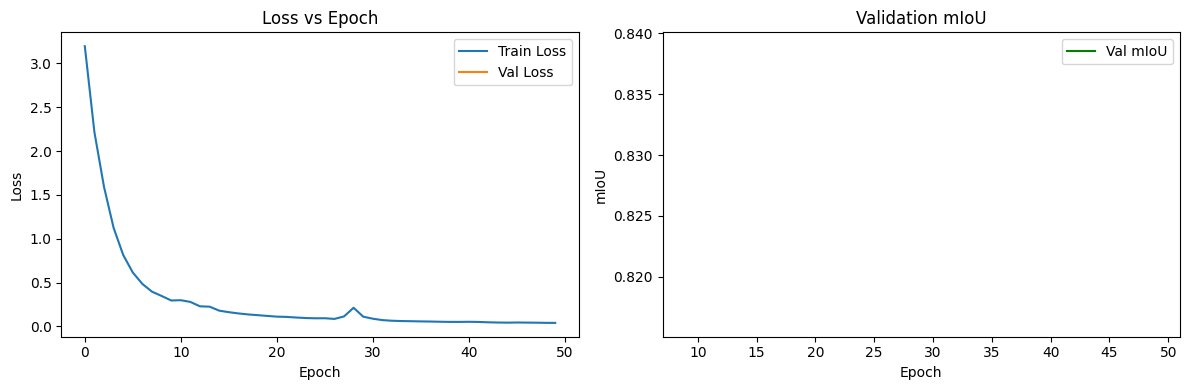

In [20]:
# Plot Loss and mIoU
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_ious, label="Val mIoU", color="green")
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.title("Validation mIoU")
plt.legend()

plt.tight_layout()
plt.show()

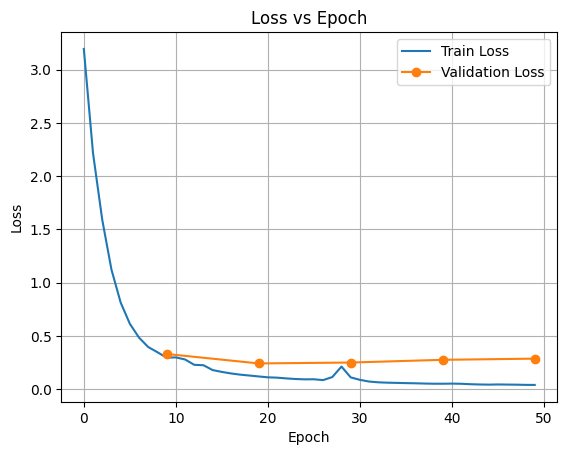

In [21]:
import matplotlib.pyplot as plt

plt.figure()

# Plot train loss (has value every epoch)
plt.plot(range(num_epochs), train_losses, label='Train Loss')

# Prepare filtered val loss and x-ticks
val_epochs = [i for i, v in enumerate(val_losses) if v is not None]
val_values = [v for v in val_losses if v is not None]

plt.plot(val_epochs, val_values, label='Validation Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
# plt.savefig('loss_plot.png')
# plt.close()


### Inference